# Coursework 2: Generative Models

#### Instructions

Please submit on CATe a zip file named *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question.
2. Your trained models as *VAE_model.pth, DCGAN_model_D.pth, DCGAN_model_G.pth*

#### Working environment:

Similarly to the previous coursework, we recommend that you use Google Colaboratory in order to train the required networks.

**The deadline for submission is 19:00, Thursday 27th February, 2020**

### Setting up working environment

For this coursework you, will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so.

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1 (50 points)
1. For the first part, you are asked to implement a Variational Autoencoder on the MNIST dataset. You will be assesed by the following:
    - **loss function and proper explanations**. You will have to choose the right loss function by properly modelling the probability distribution of the input pixels. There are more than one accepted approaches. 
    - **reconstruction error**. You will need to achieve a low enough error in order to reconstruct the images of the dataset with relatively high fidelity. You will have to provide us with your best model's training and test loss curves (both the total loss and each individual term), a few reconstructed images and a few sampled images from the latent space of the VAE in the respective cells.
    - **qualitative results**. You have to provide us with certain qualitative results that are usually used to assess the quality of the learned representations (more info below)

 
## Part 2 (50 points)
2. For the DCGAN, The success of your models will be tested as follows:
    - **By the model's training error**. You will need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. You will have to provide us with your best model's training losses curves, a discussion on how you concluded to the chosen architecture, and visualizations of generated samples in the respective cells. Your results do not have to be perfect, however a good discussion on the choice of architecture will be valued.
    - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. You will need to make a discussion on whether you noticed mode collapse or not during your experimentation and if yes, how you addressed it.

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture. You are free to choose either Multilayer Perceptrons (MLPs) or Convolutional Layers

You will need to define:
*  The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward

b. Design an appropriate loss function. There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training.


In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_VAE/MNIST'):
    os.makedirs('./CW_VAE/MNIST')


cuda:0


## Hyper-parameter selection

In [0]:
# *CODE FOR PART 1.1 IN THIS CELL*

### Choose the number of epochs, the learning rate and the batch size
num_epochs = 12
learning_rate  = 3e-4  
batch_size = 128

### Choose a value for the size of the latent space
latent_dim = 20

### Value for the beta coefficeint of the loss function
beta = 2.5

# Define here the any extra hyperparameters you used.
h_dim1 = 500  #hidden dimension in encoder and decoder

# Modify this line if you need to do any input transformations (optional).
transform = transforms.Compose([
     transforms.ToTensor(),
     lambda x: x.round()    #rounding to represent bernoulli trials                
])

# Modify the denorm function in case you need to do any output transformation when visualizing your images
denorm = lambda x : x 


## Data loading


In [0]:
train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]

save_image(fixed_input, './CW_VAE/MNIST/image_original.png')

## Model Definition

In [0]:
# *CODE FOR PART 1.1a IN THIS CELL*


class VAE(nn.Module):
    def __init__(self, in_dim=784, latent_dim=latent_dim, h_dim1=h_dim1):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
      
        # Encoder, learning the parameters of the approximate distribution
        self.fc1 = nn.Linear(in_dim, h_dim1)
        nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2_mu = nn.Linear(h_dim1, latent_dim)
        nn.init.xavier_uniform_(self.fc2_mu.weight)

        self.fc2_logvar = nn.Linear(h_dim1, latent_dim)
        nn.init.xavier_uniform_(self.fc2_logvar.weight)


        # Decoder
        self.fc3 = nn.Linear(latent_dim, h_dim1)
        nn.init.xavier_uniform_(self.fc3.weight)

        self.fc4 = nn.Linear(h_dim1, in_dim)
        nn.init.xavier_uniform_(self.fc4.weight)

        
    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        x = F.relu(self.fc1(x))

        mu = self.fc2_mu(x)
        logvar = self.fc2_logvar(x)

        return mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
    
    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        std = torch.exp(0.5*logvar)   # to obtain the std whilst working with logs
        eps = torch.randn_like(std)   # random standard normal 
        return mu + eps*std
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

        
    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        z = F.relu(self.fc3(z))
        x_recon = torch.sigmoid(self.fc4(z))   #sigmoid to force in range [0,1]
        return x_recon
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        mu_z, logvar = self.encode(x)
        z = self.reparametrize(mu_z, logvar)
        x_recon = self.decode(z)
        return x_recon, mu_z, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    
model = VAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 815824
VAE(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2_mu): Linear(in_features=500, out_features=20, bias=True)
  (fc2_logvar): Linear(in_features=500, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=784, bias=True)
)


## Training loop

In [0]:
# *CODE FOR PART 1.1b IN THIS CELL*

def loss_function_VAE(recon_x, x, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        # Binary cross-entropy loss to compare the reconstruction to actual pixels
        # Assumes bernoulli trials
        reconstruction_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        RL = reconstruction_loss

        # KLD is Kullback–Leibler divergence describing the difference between
        # the actual z prior and reconstruction function
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))
        return RL, KLD

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

model.train()

# Creating the list to store the losses with number of epochs
## Train
training_data = train_dat.data.float()
training_data /= 255    # .float() sets the values between 0 and 255
training_data = training_data.view(training_data.size(0), -1)
training_data = training_data.to(device)

train_total_loss = []
train_total_RL = []
train_total_KLD = []

## Test
testing_data = test_dat.data.float()
testing_data /= 255
testing_data = testing_data.view(testing_data.size(0), -1)
testing_data = testing_data.to(device)

test_total_loss = []
test_total_RL = []
test_total_KLD = []

# Runing the training part, as well as evaluating at each epoch on the full
# training and testing sets
for epoch in range(num_epochs):     
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        total_loss = 0

        for batch_idx, data in enumerate(loader_train):
            img, _ = data
            img = img.view(img.size(0), -1)

            img = img.to(device)
            optimizer.zero_grad()
            
            # forward
            recon_batch, mu_z, logvar = model(img)

            loss_RL, loss_KLD = loss_function_VAE(recon_batch, img, mu_z, logvar)
            loss = (loss_RL + beta*loss_KLD)
            
            # backward
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        # print out losses and save reconstructions for every epoch
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, total_loss / len(loader_train.dataset)))
        recon, _, _ = model(fixed_input.view(fixed_input.size(0), -1).to(device))
        recon = denorm(recon.cpu())
        save_image(recon, './CW_VAE/MNIST/reconstructed_epoch_{}.png'.format(epoch))

        with torch.no_grad():
            ## Train losses at the end of teh epoch
            recon_train, mu_z_train, logvar_train = model(training_data)
            train_RL, train_KLD = loss_function_VAE(recon_train, training_data, mu_z_train, logvar_train)
            
            train_loss_RL = train_RL.item()
            train_loss_KLD = beta*train_KLD.item()
            train_loss = train_loss_RL + train_loss_KLD

            train_total_loss.append(train_loss/len(training_data))
            train_total_RL.append(train_loss_RL/len(training_data))
            train_total_KLD.append(train_loss_KLD/len(training_data))
            print('Train set loss: {:.4f}'.format(train_total_loss[-1]))
            
            ## Test losses at the end of the epoch
            recon_test, mu_z_test, logvar_test = model(testing_data)
            test_RL, test_KLD = loss_function_VAE(recon_test, testing_data, mu_z_test, logvar_test)
            
            test_loss_RL = test_RL.item()
            test_loss_KLD = beta*test_KLD.item()
            test_loss = test_loss_RL + test_loss_KLD

            test_total_loss.append(test_loss/len(testing_data))
            test_total_RL.append(test_loss_RL/len(testing_data))
            test_total_KLD.append(test_loss_KLD/len(testing_data))
            print('Test set loss: {:.4f}'.format(test_total_loss[-1]))

        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 


# save the model 
torch.save(model.state_dict(), './CW_VAE/MNIST/VAE_model.pth')

epoch [1/12], loss:222.7175
Train set loss: 179.7412
Test set loss: 178.5193
epoch [2/12], loss:163.5777
Train set loss: 160.9766
Test set loss: 160.1934
epoch [3/12], loss:149.5652
Train set loss: 153.0903
Test set loss: 152.1772
epoch [4/12], loss:142.4160
Train set loss: 148.9107
Test set loss: 148.0098
epoch [5/12], loss:137.8642
Train set loss: 146.4904
Test set loss: 145.5708
epoch [6/12], loss:134.6963
Train set loss: 144.1744
Test set loss: 143.1908
epoch [7/12], loss:132.2919
Train set loss: 142.7826
Test set loss: 141.6738
epoch [8/12], loss:130.4972
Train set loss: 141.5360
Test set loss: 140.3782
epoch [9/12], loss:128.9854
Train set loss: 140.6275
Test set loss: 139.7059
epoch [10/12], loss:127.6426
Train set loss: 139.9416
Test set loss: 139.1477
epoch [11/12], loss:126.6148
Train set loss: 139.0158
Test set loss: 138.0436
epoch [12/12], loss:125.6940
Train set loss: 138.8516
Test set loss: 138.0155


### Your explanations about the loss function here:

Two terms in the Evidence Lower Bound (ELBO) VAE loss fucntion can be optimized: the log likelihood and Kullback Lieblers Divergence (KLD). The log likelihood corresponds to the reconstruciton loss of the data, i.e. how well the outputs match the inputs. The data was assumed to be binary in this experiment as the pixel values were close to 0 and 1 throughout the images. Hence, each pixel of the input data is seen as a independent Bernoulli observation, which can take the value 0 or 1. In this set-up, the binary-cross entropy loss function could be used for the log likelihood loss. This essentialy boils down to categorising each pixel to 0 or 1.

This assumption required to round the input data to 0 and 1 as a preprocessing step for each pixel to represent a Bernoulli trial. Thus the x.round() function has been added in the transforms, and the sigmoid function is applied on the networks output to constrain its range to [0,1].

In the implementation of the reduction loss, the 'sum' reduction is used as  the loss is computed over each of the Bernoulli observations: the 784 observation per image multiplied by the size of the minibatch.

The expression for KLD has been taken from [1], assuming a multivariate normal distribution, with diagonal covariance for the variational approximate posterior q(z|x). This term retales the difference between the variational approximate posterior q(z|x) and the set prior p(z) (Gaussian normal).


The beta parameter impacted the quality of the reconstruction and the entanglement of the latent space simultaneously. Indeed, when beta was increased, the reconstruction quality reduced whilst the disentanglement in the latent space increased. By increasing beta, the weight of the reconstruction over the total loss decreases, hence the network relatively focuses more on the KLD. By focusing on the KLD (which acts as a regularizer), the variational approximate posterior gets closer to the actual prior normal distribution p(z), which helps to disentangle its features.
On the other hand, decreasing beta reinforced the importance of the reconstruction loss, leading to a better reconstruction performance by the variational autoencoder.

[1] Kingma, Diederik P and Welling, Max. Auto-Encoding Variational Bayes. InThe 2nd International Conferenceon Learning Representations (ICLR), 2013.

## Part 1.2 (10 points)

a. Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). 

b. Provide a brief analysis of your loss curves. What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)? Can you intuitively explain if this behaviour is desirable? Have you observed posterior collapse during traing (i.e. when the KL is too small during the early stages of training)? If yes, how did you mitigate it? How did this phenomenon reflect on your output samples? 

c. Visualize a subset of the images of the test set and their reconstructions as well as a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation) .Please deliver the notebook including the outputs of the cells below.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Text(0, 0.5, 'Test Losses')

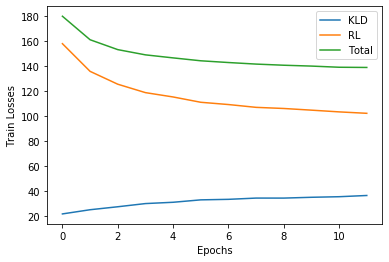

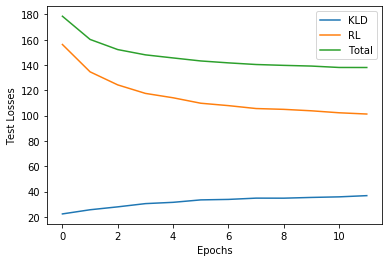

In [0]:
# *CODE FOR PART 1.2a IN THIS CELL*
plt.plot(list(range(num_epochs)), train_total_KLD, \
         list(range(num_epochs)), train_total_RL, \
         list(range(num_epochs)), train_total_loss)
labels=['KLD', 'RL', 'Total']
plt.legend(labels)
plt.xlabel('Epochs')
plt.ylabel('Train Losses')
plt.savefig('losses' + '.eps', bbox_inches='tight')

plt.figure()
plt.plot(list(range(num_epochs)), test_total_KLD, \
         list(range(num_epochs)), test_total_RL, \
         list(range(num_epochs)), test_total_loss)
plt.legend(labels)
plt.xlabel('Epochs')
plt.ylabel('Test Losses')

### Your answer to 1.2b :
The general trend for the reconstruction and KLD losses respectively are similar in the train and test datasets. The reconstruction loss is seen to decrease, whilst the KLD is seen to slolwly (when compared with the slope of the reconstruction loss) increase.

The decrease in reconstruction loss highlights the increasing performance in data reconstruction. The outputs will match the input closer. To do so, the encoder requires the latent sapce features to be very well structured in order to efficiently separate between the different numbers to be reconstructed. If the loss was solely the reconstruction loss (setting beta to 0), the latent representation would be very sparse allowing for easy separation.

On the other hand, the KLD tries to match the 0 mean and 1 standard deviation Gaussian distribution of the prior on the q(x|z) distirbution (on the whole image samples). Hence, it will tend to decrease the structure in the latent space representation to match this distribution. The loss functions observed translates that, to reach a good reconstruction, structure must be added within the latent space features, which leads to a slight increase in the KLD loss. As the reconstruction loss is much greater in magnitude, the optimiser favours its decrease at the price of a small increase in KLD. This behaviour thus seems desirable.

The fact that the total loss in both the test and train settings is seen to decrease suggests that the network is not overfitting.

In VAE, posterior collapse corresponds to the situation where the variational distribution q(z|x) collapses to the prior p(z). In such a situation, the network will learn to ignore a subset of the latent space z to reconstruct x as the latent space will not hold any information concerning x.

A very high KLD will lead to such a behaviour because the latent space will not porvide any information concerning the input as the distribution matches that which is not conditioned by x. Posterior collapse was observed when setting a very high beta (~20). The neural network converged to a local minimum, and the network output was a single digit (indepedently of the input), which looked like the average of all the digits (ie. like a filled grey 0). The sampling appeared to be limited to a subset of the latent space. This behaviour can be justified by the fact that the a very high beta tends increases the weight of the KLD. Hence the KLD loss is optimised in priority, and the reconstruction loss is neglected. Thus, to mitigate this behaviour, I have reduced the beta coefficent.

torch.Size([32, 1, 28, 28])


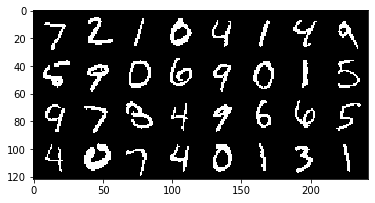

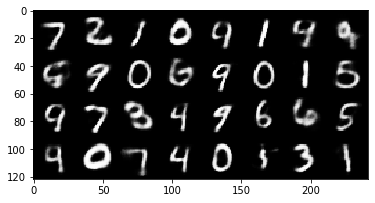

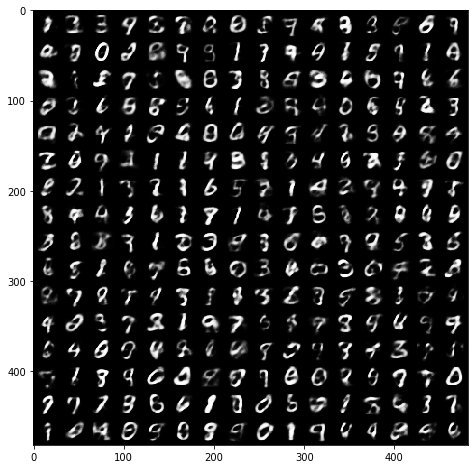

In [0]:
# *CODE FOR PART 1.2c IN THIS CELL*

# load the model
model = VAE().to(device)
model.load_state_dict(torch.load('./CW_VAE/MNIST/VAE_model.pth'))
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch, _, _ = model(fixed_input.view(fixed_input.size(0),-1).to(device))
    recon_batch = recon_batch.view(fixed_input.size(0), -1, 28, 28)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    print(recon_batch.shape)
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)
    
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    # decoding the latent space and reshaping the output
    samples = model.decode(z)  
    samples = samples.view(samples.size(0), -1, 28, 28)
    #######################################################################
    #                       ** END OF YOUR CODE **
    ####################################################################### 
    
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)

## Part 1.3 (15 points)

### Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Extract the latent representations of the test set and visualize them using T-SNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or PCA. What do you observe? Discuss the structure of the visualized representations. Please use different colours for each digit class.

b. Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

3.8291924
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.032s...
[t-SNE] Computed neighbors for 10000 samples in 5.498s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.359270
[t-SNE] KL divergence after 50 iterations with early exaggeration: 93.591736
[t-SNE] KL divergence after 300 iterations: 3.004161


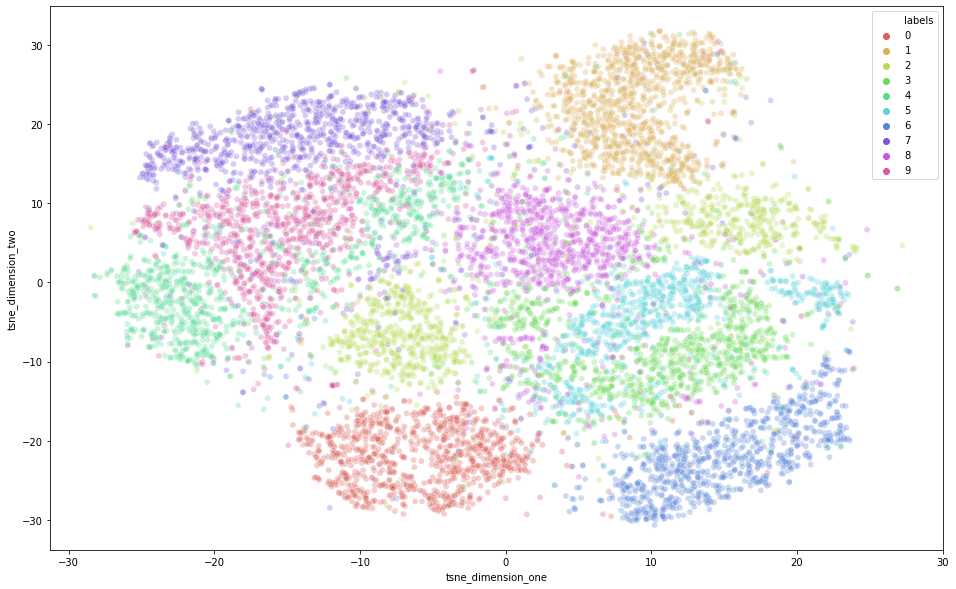

In [0]:
# *CODE FOR PART 1.3a IN THIS CELL*
## Please note that for aesthetic reasons I have decided to import seaborn, 
## to plot the tsne 
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE

test_data = ((loader_test.dataset.data).view(-1,1,28,28)).float()
test_data = test_data/255
test_labels = loader_test.dataset.targets #test_labels

def tsne_and_plot(test_data, test_labels):
    with torch.no_grad():
        mu_z, logvar = model.encode(test_data.view(test_data.size(0), -1).to(device))
        latent_rep = model.reparametrize(mu_z, logvar)
        latent_rep = latent_rep.cpu()
        latent_rep=latent_rep.numpy()
    print(latent_rep.max())
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(latent_rep)

    df = pd.DataFrame(tsne_results)
    df.columns = ["tsne_dimension_one", "tsne_dimension_two"]
    df["labels"] = test_labels

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne_dimension_one", y="tsne_dimension_two",
        hue="labels",
        palette=sns.color_palette("hls", 10),
        data=df,
        legend="full",
        alpha=0.3
    )

    return

tsne_and_plot(test_data, test_labels)

### Your answer to 1.3a here:

T-SNE was used to visualise the latent representation learned by the model. From the plot, it appears that when the network manages to efficiently reconstruct the inputs, the latent space representation (using two dimensions) segregates between the different labels. Each color is mostly grouped into one region, and the labels do not overlap with any other.

The latent space appears as slightly sparse in between regions representing different numbers revealing that the latent space acts like a feauture extractor and clustering method. This representation has significantly deviated from the 0 mean and standard normal deviation of the prior showing that the reconstruction loss was optimized over the KLD.

It is interesting to note that when the beta value was increased (~5), the latent space representation lost this structure and the labels were not separated anymore. This is expected as the variational distribution would be forced to match its prior (standard Gaussian) more closely.

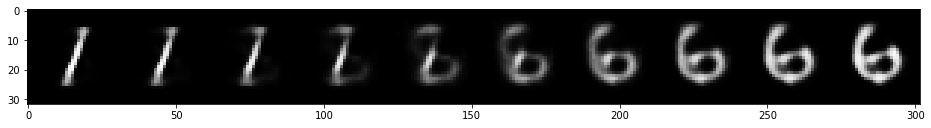

In [0]:
# *CODE FOR PART 1.3b IN THIS CELL*
testing_labels = loader_test.dataset.targets #test_labels

def get_latent_rep(a):
    """Obtains the latent representation of an input.
    input: integer digit between 0 and 9
    output: a sample latent representation of this digit"""
    data = testing_data[(testing_labels==a)]
    idx = torch.randint(0,len(data),(1,)).to(device)
    mu, logvar = model.encode(data[idx].flatten().to(device))
    latent_rep = model.reparametrize(mu, logvar)
    return latent_rep

def linear_inter_representation(a, b):
    """Constructs and plots the linear interpolation between latent representations
    of digits a and b
    input: a, digit between 0 and 9
         b, digit between 0 and 9
    output: -"""
    latent_rep_a = get_latent_rep(a)
    latent_rep_b = get_latent_rep(b)
    val = torch.linspace(0, 1, 10).to(device)

    with torch.no_grad():
    interpolation = model.decode(val.view(-1, 1) * latent_rep_b.view(1,-1) + (1-val.view(-1, 1))* latent_rep_a.view(1,-1))
    interpolation = interpolation.view(interpolation.size(0), -1, 28, 28)
    interpolation_images = make_grid(denorm(interpolation), nrow=10, padding=2, normalize=False,
                                   range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (16,8))
    show(interpolation_images)
return

linear_inter_representation(1, 6)

### Your answer to 1.3b here:

The linear interpolation images above show that the transition starts off from a clear representation of the first digit and ends up in a clear representation of the second digit. It also highlights that images in between these two look less like actual digits. This transition reveals information on the structure of the latent space. Indeed, this highlights that the latent space is slightly sparse as linear interpolation between two samples do not corrrespond to any learned data in the latent space. Hence, there must be regions in the latent space which does not map to any digit. In my example, in the middle region, the image does not look like a 1 nor a 6. It looks like the mix of both where the 6 gradually appears more and more. Thus the middle region correpsonds to a space which does not specifically reconstruct a learnt digit.  

(Oppositely, when beta was set to higher values, there was much less structure in the latent representation and the features were not sparsely distributed. This led to an interpolation where the transition form a number to another sometimes included the representation of other digits, and more representations in the linear interpolation looked like learnt parameters.)

## Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures, tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with: 

- your best trained model (which we will be able to run), 
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse), 
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case. 
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse. 

_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get full marks. The attached model does not have to be perfect._

### Part 2.1 (30 points)
**Your Task**: 

a. Implement the DCGAN architecture. Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

b. visualize images sampled from your best model's generator.

c. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).

For b. the code is already given. Make sure that the version of the notebook you deliver includes these results. 

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions. 
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`). 
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small receptive fields, max pooling, RELU activations), in order to narrow down your possible choices.

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

**2.1c)**

To start off the analysis of GANS, a simple convolutional neural network with 3 convolutional layers in the generator and 2 transpose convolutional layers were used. A stride of 2 was used to reduce the size of the image throuh the generator, and then decrease it anew through the discriminator. Common practices of using small kernels (4\*4 max), weights initialisation and RELU activation fucntions were used. A latent space of 2 was used for initial experiments. This set-up appeared to be efficient at first, but quickly revealed some of its flaw: convergence failure. The loss of the discriminator initially increased before quickly dropping to 0. Similarly the generator loss tend to 0 and the generation revealed to be grey images similar to random noise. This behaviour was supposed to be due to the insufficient capacity of the discriminator and generator. Hence, four convolutional and transpose convolutional layers were chosen for the generator and discriminator in the next experiments (their sizes are the same as that of my final model shown below).

After evaluating this architecture with different number of epochs, mode collapse was observed. Even though, the loss function did not reveal the exact cyclical behaviour mode collapse seems to generate (from litterature), the generated images were similar to one another and the discriminator loss was stable around 0.5 (implying pure guessing). This suggested that the generator had learned to represent similar outputs from different inputs in order to trick the discriminator. To circumvent this issue, the latent space was increased (by step sizes of 10) up to 32 dimensions and batchnormalisation was added after the convolutional layers in the network. The greater feature space was assumed to provide more generation power to the generator and prevent it from providing mode solutions only. The batch normalisation reduced the covariance shift at each convolutional layer and helped the latter to learn more independently from one another. This allowed for the deeper achitercture envisonned and for a faster learning. In that set up, the generator loss was seen to decrease and the discriminator loss to increase with epochs, as desired. However the trends were too unstable.

Indeed, the increase in the discriminator loss was expected to be followed by a stabilsation region, where the discriminator is effectively just guessing; but it wasn't. The Leaky Relu was then added in the discriminator (as suggested) and proved to reduce the variance in the losses, especialy the generator loss. This is probably due to the fact that the Leaky Relu helped the discriminator gradient propagate through the network and up to the genearator. A gradient would be propagated through even though the node value was samller than 0 (disimilar to Relu function) and this helped the generator to learn.

To help the discriminator stablise, two different schedulers were added to the optimiser. The learning rate of the generator was updated every two epochs whilst that of the discriminator at every epoch. This was done to allow discriminator to have a more stable learning than that of the generator (required as the variance of the discrimnator loss was greater). With this set-up, the discrimnator loss actually increased (as expected), but a convergence failure was observed anew after more than 20 epochs, leading to noisy grey results. Hence the schedulers were changed. The schedulers were set to update the learning rates of the two networks at the same rate. This provided much more stable losses. This also allowed to change the learning rate form 1e-4 to 3e-4 and correspond to my final architecture presented here.

Throughout the experiments, the number of epochs was varied between 20 and 40, whilst the final model is trained on 20 epochs. Tranforms were added to the input data to increase diversity and force the discrimantor to generalise more (not settling on a reduced number of features to classify). 

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# device selection
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

if not os.path.exists('./CW_DCGAN'):
    os.makedirs('./CW_DCGAN')

cuda:0


### Data loading

In [0]:
batch_size = 128
image_size = 32
NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.Resize(image_size),
     transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'

cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameter selection

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*

### Choose the number of epochs, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 20
learning_rate  = 3e-4
latent_vector_size = 32
###

# Define here other hyperparameters that you used.
train_image_channels = 3

generator_feature_maps = 32
discriminator_feature_maps = 32

In [0]:
# *CODE FOR PART 2.1 IN THIS CELL*


class Generator(nn.Module):
    def __init__(self, latent_vector_size=latent_vector_size,
                 generator_feature_maps=generator_feature_maps,
                 train_image_channels=train_image_channels):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        
        self.hidden0 = nn.Sequential(
            nn.ConvTranspose2d(latent_vector_size, generator_feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(generator_feature_maps * 8),
            nn.ReLU(True)
        )

        self.hidden1 = nn.Sequential(
            nn.ConvTranspose2d(generator_feature_maps * 8, generator_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_feature_maps * 4),
            nn.ReLU(True)  
        )

        self.hidden2 = nn.Sequential(
            nn.ConvTranspose2d(generator_feature_maps * 4, generator_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_feature_maps * 2),
            nn.ReLU(True)
        )

        self.hidden3 = nn.Sequential(
            nn.ConvTranspose2d(generator_feature_maps*2, train_image_channels, 4, 2, 1, bias=False),
            nn.Tanh()            
        )
        
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        x = self.hidden3(self.hidden2(self.hidden1(self.hidden0(z))))
        
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        return x

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self, train_image_channels=train_image_channels,
                 discriminator_feature_maps=discriminator_feature_maps):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        
        self.hidden0 = nn.Sequential( 
            nn.Conv2d(train_image_channels, discriminator_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.hidden1 = nn.Sequential(
            nn.Conv2d(discriminator_feature_maps, discriminator_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.hidden2 = nn.Sequential(
            nn.Conv2d(discriminator_feature_maps * 4, discriminator_feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.hidden3 = nn.Sequential(
            nn.Conv2d(discriminator_feature_maps * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
    def discriminator(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.hidden3(self.hidden2(self.hidden1(self.hidden0(x))))
        #######################################################################
        #                       ** END OF YOUR CODE **
        ####################################################################### 
        
        return out

    def forward(self, x):
        out = self.discriminator(x)
        return out.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 790400
Generator(
  (hidden0): Sequential(
    (0): ConvTranspose2d(32, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (hidden3): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
)


Total number of parameters in Discriminator is: 596224
Discriminator(
  (hidde

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5


# Setting up the schedulers to decrease the learning rate and stabilise learning
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=2, gamma=0.95)

optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=2, gamma=0.95)

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [0]:
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    train_loss_D = 0
    train_loss_G = 0
    for i, data in enumerate(loader_train, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################device
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
          % (epoch, num_epochs, i, len(loader_train),
              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    ################################
    # Take a step in the scheduler to decay the learning rate
    if schedulerD is not None:
        schedulerD.step()
    if schedulerG is not None:
        schedulerG.step()
    ################################

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), './CW_DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()).float(), './CW_DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
            
# save losses and models
torch.save(model_G.state_dict(), './CW_DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW_DCGAN/DCGAN_model_D.pth')

[0/20][382/383] Loss_D: 0.7090 Loss_G: 2.9312 D(x): 0.6870 D(G(z)): 0.2252 / 0.0731
[1/20][382/383] Loss_D: 0.9419 Loss_G: 3.1791 D(x): 0.6646 D(G(z)): 0.2722 / 0.0703
[2/20][382/383] Loss_D: 0.8378 Loss_G: 1.7949 D(x): 0.6459 D(G(z)): 0.2073 / 0.2138
[3/20][382/383] Loss_D: 1.1332 Loss_G: 2.3056 D(x): 0.4678 D(G(z)): 0.1346 / 0.1477
[4/20][382/383] Loss_D: 1.1594 Loss_G: 1.4470 D(x): 0.4518 D(G(z)): 0.1401 / 0.3173
[5/20][382/383] Loss_D: 0.7231 Loss_G: 2.0006 D(x): 0.7294 D(G(z)): 0.2876 / 0.1668
[6/20][382/383] Loss_D: 0.7380 Loss_G: 1.9908 D(x): 0.6931 D(G(z)): 0.2644 / 0.1752
[7/20][382/383] Loss_D: 0.7800 Loss_G: 3.1873 D(x): 0.8903 D(G(z)): 0.4482 / 0.0539
[8/20][382/383] Loss_D: 0.7703 Loss_G: 1.6185 D(x): 0.6542 D(G(z)): 0.2408 / 0.2396
[9/20][382/383] Loss_D: 0.7474 Loss_G: 2.1068 D(x): 0.7381 D(G(z)): 0.3224 / 0.1406
[10/20][382/383] Loss_D: 0.8515 Loss_G: 2.4296 D(x): 0.8305 D(G(z)): 0.4390 / 0.1131
[11/20][382/383] Loss_D: 1.7055 Loss_G: 4.2428 D(x): 0.8121 D(G(z)): 0.6825

### Generator samples

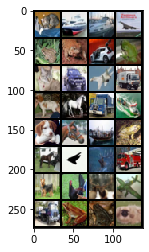

In [0]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

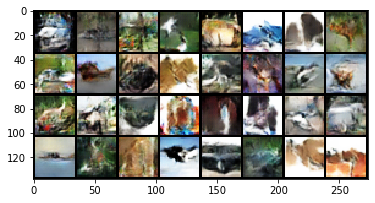

In [0]:
# load the model
model_G.load_state_dict(torch.load('./CW_DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images\
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Part 2.2 (10 points)

### Train losses curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

The code for generating the plot is already given. Make sure that the version of the notebook you deliver includes these results.

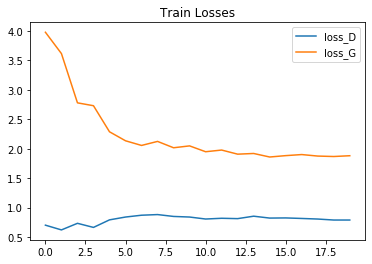

In [0]:
import matplotlib.pyplot as plt
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='loss_D')
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

#### Analysis

The plot reveals that the generator loss decreases with epochs, whilst the discirminator slowly rises and then settles. These trends reveal that the generator improves at generating images that resemble the real samples whilst the discriminator worstens at separating between real and fake images. This is the theoretically desried behaviour in our minmax problem as the goal is to decrease the loss of the generator which tries to fool the discriminator. Thus, by imporving the generator,the task of the discriminator becomes harder, its perfomance worsents and its loss increases. We expected to see the discriminaotr loss to stabilise at 0.5 with the number of epochs as it would reach a point where it would randomly guess between real and fake for each sample. The plots show a stabilisation around 0.75, which suggest that an optimal solution has not been reached yet (we want 0.5) but that the trends are desired and coherent with our goal.

### Part 2.3 (10 points) 
**Your task:** 

Based on the images created by your generator using the `fixed_noise` vector during training, provide a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explain what you did in order to cope with mode collapse.

#### Answer:

Based on the images generated using the fixed_noise, it is assumed that mode collapse does not appear in this network. Indeed, the images do not repeat and are different one from another.

During exploration, mode collapse had been observed when the latent space was reduced to 2 features and when the discrimnator had too little parameters. The discrimnator sometimes got stuck in local minima and based its classifying on too little features, which allowed the generator to fool it by generating the same images over and over again, based on a small number of features. The discrimniator could not reject the generators image, and hence led to the generator producing its modes (best representations) for multiple different sets of input noise in order to reduce its overall loss.

To cope with mode collapse, the latent dimension space and the learning rate (to escape some small local minima) were increased. The greater latent space allowed the generator to have a greater generation power and prevented from creating the same modes over and over again.

If these methods had not been fruitful, the implementation of the Wasserstein loss function to reject outputs on which the generator stabilises, as well as label smoothing would have been considered. Label smoothing would have been used to prevent the discriminator from being over confident, which could have potentially forced the generator to create different image whislt seeking to fool the latter.

However, the first two above mentioned tricks (increasing the latent space and learning rate) were sufficient and nor the Wasserstein loss nor the label smoothing were implemented.